In [1]:
import pandas as pd 
import numpy as np 
import nltk 
import glob

data = []
all_files = glob.glob(r'data' + "/*.csv")

for filename in all_files:
    d = pd.read_csv(filename)
    data.append(d)

df = pd.concat(data, sort=True)

df.sample(5)

,Unnamed: 0,comment,flair
1520,1520,More and more I’m starting to think that I’ll ...,:centrist: - Centrist
2626,2626,Can I at least just get a large rock from a ta...,:left: - Left
10542,10542,Ask Flint about water and ask Texas about elec...,:centrist: - Centrist
1004,1004,**WHAT HAVE YOU DONE?! THE WRATH OF THE ANCAPS...,:right: - Right
6825,6825,Libleft simping as always,:libright: - LibRight


## Data Preprocessing

In [2]:
for c in df.columns:
    na_count = df[c].isna().sum()
    if na_count > 0:
        print(f'{c} has {na_count} nulls')
    else:
        print(f'{c} has no nulls')

Unnamed: 0 has no nulls
comment has no nulls
flair has no nulls


In [3]:
df = df.drop('Unnamed: 0', axis=1)

In [4]:
#cleaing flair values
df['flair'] = df['flair'].astype(str)
def get_last(text):
    tlist = text.split()
    return tlist[-1]

df['flair'] = df.apply(lambda x: get_last(x['flair']), axis=1)

In [5]:
df['flair'].unique()

array(['Right', 'LibRight', 'LibLeft', 'Centrist', 'AuthCenter',
       'LibCenter', 'AuthLeft', 'AuthRight', 'Left'], dtype=object)

In [6]:
df['flair'].value_counts()

LibRight      13948
Centrist      10709
LibLeft        7957
LibCenter      7694
Right          6205
AuthRight      5236
AuthCenter     5037
Left           3388
AuthLeft       3124
Name: flair, dtype: int64

### Text Preprocessing

In [7]:
#remove stopwords, punctuations and expand contractions
import string
from nltk.corpus import stopwords
import contractions
import re

#stop = stopwords.words('english')
punc = string.punctuation
 
def clean_text(text):
    #expand contractions
    text_contract_fixed = contractions.fix(text)
    #stop_removed = ' '.join([t for t in text_contract_fixed.lower().split() if t not in stop])
    #remove punctiations
    punc_removed = ' '.join(s for s in text_contract_fixed.split() if s not in punc)
    #num_removed = re.sub(r'\d+', '', punc_removed)
    #no_doublespace = re.sub('\s+', ' ', punc_removed).strip()
    return punc_removed

df['comment'] = df.apply(lambda x: clean_text(x['comment']), axis=1)

### Evaluating Word Counts
Every input in the model will need to have the same length. Shorter inputs can be padded with 0's and longer inputs can be trimmed. There needs to be a set word length to minimize padding and trimming.

In [8]:
#create word count column
df['word_count'] = df['comment'].apply(lambda x: len(str(x).split(" ")))

print('Max:', df['word_count'].max())
print('Min:', df['word_count'].min())
print('Mean:', df['word_count'].mean())
print('Standard Deviation:', df['word_count'].std())
print('Nulls:', df['comment'].isna().sum())

Max: 2500
Min: 1
Mean: 15.990205061771304
Standard Deviation: 34.16996008147011
Nulls: 0


In [9]:
#drop rows with 2 or less words
df = df[df['word_count']>2]

print('Max:', df['word_count'].max())
print('Min:', df['word_count'].min())
print('Mean:', df['word_count'].mean())
print('Standard Deviation:', df['word_count'].std())
print('Nulls:', df['comment'].isna().sum())

Max: 2500
Min: 3
Mean: 17.625480997311687
Standard Deviation: 35.665680519638244
Nulls: 0


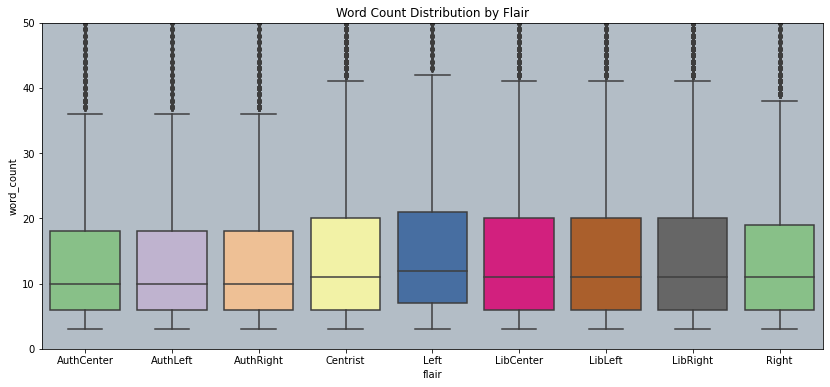

In [10]:
import matplotlib.pyplot as plt 
import seaborn as sns 
def plot_box(data, x, y):
    plt.style.use('seaborn-deep')
    fig, ax = plt.subplots(figsize = (14,6))
    ax = sns.boxplot(data=data.sort_values(x), x= x, y= y, palette= 'Accent')
    ax.set_title('Word Count Distribution by Flair')
    ax.set_facecolor('#b3bdc6')
    ax.set(ylim=(0, 50))

plot_box(df, 'flair', 'word_count')

The input length will be 40, as most comments with more words are outliers in length.

## Create Word Tokens

In [11]:
#tokenizing words

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Maximum number of words to keep based on frequency
MAX_WORDS = 50000
#Max number of words in each comment. 
MAX_LENGTH = 40

tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True, oov_token='oov')
tokenizer.fit_on_texts(df['comment'].values)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('Found %s unique tokens.' % len(word_index))

#Rule of thumb: embedding vector dimension should be the 4th root of the number of categories
EMBEDDING_DIM = round(float(len(word_index)**0.25))

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

X = tokenizer.texts_to_sequences(df['comment'].values)
X = pad_sequences(X, maxlen=MAX_LENGTH, truncating='post', padding='post')
print('Shape of data tensor:', X.shape)

Found 41979 unique tokens.
Shape of data tensor: (56913, 40)


In [12]:
import io
import json
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

## Train-Test Split and Over Sampling

In [21]:
from sklearn.model_selection import train_test_split

y = df['flair']

X_train, X_test, y_train, y_test = train_test_split(  
                    X, y, test_size=0.25, random_state=4)

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=3, k_neighbors=5)
X_train,y_train = smote.fit_resample(X_train,y_train)

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(85194, 40) (85194, 9)
(14229, 40) (14229, 9)


In [23]:
distinct = y_train.drop_duplicates()
distinct

,AuthCenter,AuthLeft,AuthRight,Centrist,Left,LibCenter,LibLeft,LibRight,Right
0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0
7,0,1,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0
10,0,0,1,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,1
23,0,0,0,0,1,0,0,0,0


## Model Creation

In [24]:
from keras.models import Sequential
from keras import layers 
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

NUM_CLASSES = y_train.shape[1]

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=X.shape[1]))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 14)            587720    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               73216     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1161      
Total params: 662,097
Trainable params: 662,097
Non-trainable params: 0
_________________________________________________________________


In [25]:
from keras.callbacks import EarlyStopping

epochs = 5
batch_size = 50

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', mode= 'max', patience=4, min_delta=0.0001)])

Epoch 1/5
1364/1364 [==============================] - 82s 58ms/step - loss: 2.1532 - accuracy: 0.1459 - val_loss: 3.1960 - val_accuracy: 6.4558e-04
Epoch 2/5
1364/1364 [==============================] - 81s 60ms/step - loss: 2.1178 - accuracy: 0.1662 - val_loss: 3.1936 - val_accuracy: 0.0012
Epoch 3/5
1364/1364 [==============================] - 82s 60ms/step - loss: 2.0575 - accuracy: 0.1958 - val_loss: 3.7229 - val_accuracy: 1.7607e-04
Epoch 4/5
1364/1364 [==============================] - 82s 60ms/step - loss: 2.0080 - accuracy: 0.2136 - val_loss: 3.7168 - val_accuracy: 0.0020
Epoch 5/5
1364/1364 [==============================] - 82s 60ms/step - loss: 1.9630 - accuracy: 0.2243 - val_loss: 4.0927 - val_accuracy: 0.0051


## Model Evaluation

In [26]:
accr = model.evaluate(X_test,y_test)
print(f'Test set\n  Loss: {accr[0]}\n  Accuracy: {accr[1]}')

445/445 [==============================] - 4s 8ms/step - loss: 2.2376 - accuracy: 0.1835
Test set
  Loss: 2.2375540733337402
  Accuracy: 0.18349848687648773


In [27]:
#converting predictions to 1 and 0. Taking largest probalility as 1 and rest as 0
preds = model.predict(X_test)

all_predicts = []

for row in preds:
    bool_predict = []
    for p in row:
        if p == max(row):
            bool_predict.append(1)
        else:
            bool_predict.append(0)
    all_predicts.append(bool_predict)

print(all_predicts[:5])

[[0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0]]


In [28]:
from sklearn.metrics import accuracy_score

print('Test Set Accuracy Score:', accuracy_score(y_test,all_predicts))

Test Set Accuracy Score: 0.1834984890013353


In [29]:
model.save("C:/Users/austi/reddit_text/poli_comp_text_class")

INFO:tensorflow:Assets written to: C:/Users/austi/reddit_text/poli_comp_text_class\assets
